<a href="https://colab.research.google.com/github/miltiadiss/Decision-Theory/blob/main/tsla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
desired_directory = '/content/drive/MyDrive/alphavantage' #define current directory in google drive
os.chdir(desired_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import requests

#API_KEY = YZFYJ9DASTWXPXOS
#STOCK_SYMBOL = TSLA

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=full&apikey=YZFYJ9DASTWXPXOS'
r = requests.get(url)
json_data = r.json()

#print(json_data)

<ipython-input-2-82b09dc628ab>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = gaussian_filter1d(df['Close'], sigma=sigma)


Data saved to close_prices.csv


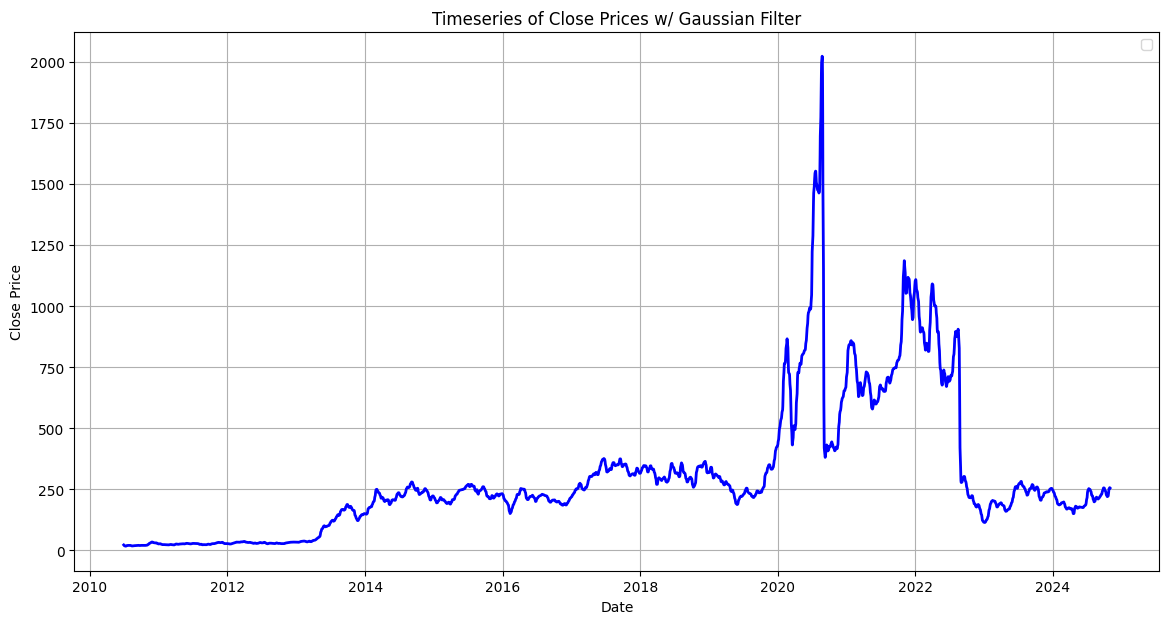

In [2]:
import json
import csv
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

# Extract "Time Series (Daily)" part from JSON
time_series = json_data.get("Time Series (Daily)", {})

# Prepare data for CSV
csv_data = [("Date", "Close")]  # Header for CSV file

# Loop through each date and get the "close" price
for date, daily_data in time_series.items():
    close_price = daily_data.get("4. close", None)
    if close_price:
        csv_data.append((date, close_price))

# Write data to CSV file
csv_file = 'close_prices.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Data saved to {csv_file}")

# Read CSV file and store the data in a DataFrame
df = pd.read_csv('close_prices.csv', parse_dates=['Date'])
df = df.sort_values(by='Date')  # Sorting by 'Date'
df = df[df['Date']<='2024-10-31']

# Apply Gaussian Filter in 'Close' prices for smoothing
sigma = 2
df['Close'] = gaussian_filter1d(df['Close'], sigma=sigma)

# Plot the smoothed timeseries
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], color='blue', linewidth=2)

plt.title('Timeseries of Close Prices w/ Gaussian Filter')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# Create a function to train and evaluate polynomial regression with L1-Normalization
# for different polynomial degrees
def polynomial_regression_model(degree, N, data, alpha=1.0):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training and validation sets
    train_data = data[data['Date'] < '2024-01-01']
    validation_data = data[data['Date'] >= '2024-01-01']

    # Prepare features and target for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Create and fit the Lasso regression model with L1 regularization
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_poly, y_train)

    # Make predictions using the validation set
    y_pred = model.predict(X_val_poly)

    # Evaluate the model metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    # Get model parameters (weights)
    weights = model.coef_
    bias = model.intercept_

    return mae, rmse, mse, y_val, y_pred, validation_data['Date'], weights, bias

[ 0.00000000e+00  1.23557264e+00 -1.16670912e-01 ... -8.86009920e-27
 -8.91215393e-27 -8.15217172e-27]
         Date  Predicted Close
0  2024-11-01       219.781874
1  2024-11-02       220.685003
2  2024-11-03       224.382588
3  2024-11-04       231.689578
4  2024-11-05       241.269921
5  2024-11-06       250.126815
6  2024-11-07       256.089572
7  2024-11-08       259.667715
8  2024-11-09       262.969055
9  2024-11-10       267.222632
10 2024-11-11       218.905573
11 2024-11-12       218.361481
12 2024-11-13       220.610201
13 2024-11-14       227.318184
14 2024-11-15       237.383681
15 2024-11-16       247.160213
16 2024-11-17       254.188965
17 2024-11-18       260.379135
18 2024-11-19       269.681336
19 2024-11-20       282.970964
20 2024-11-21       218.708911
21 2024-11-22       216.593992
22 2024-11-23       217.021206
23 2024-11-24       222.760081


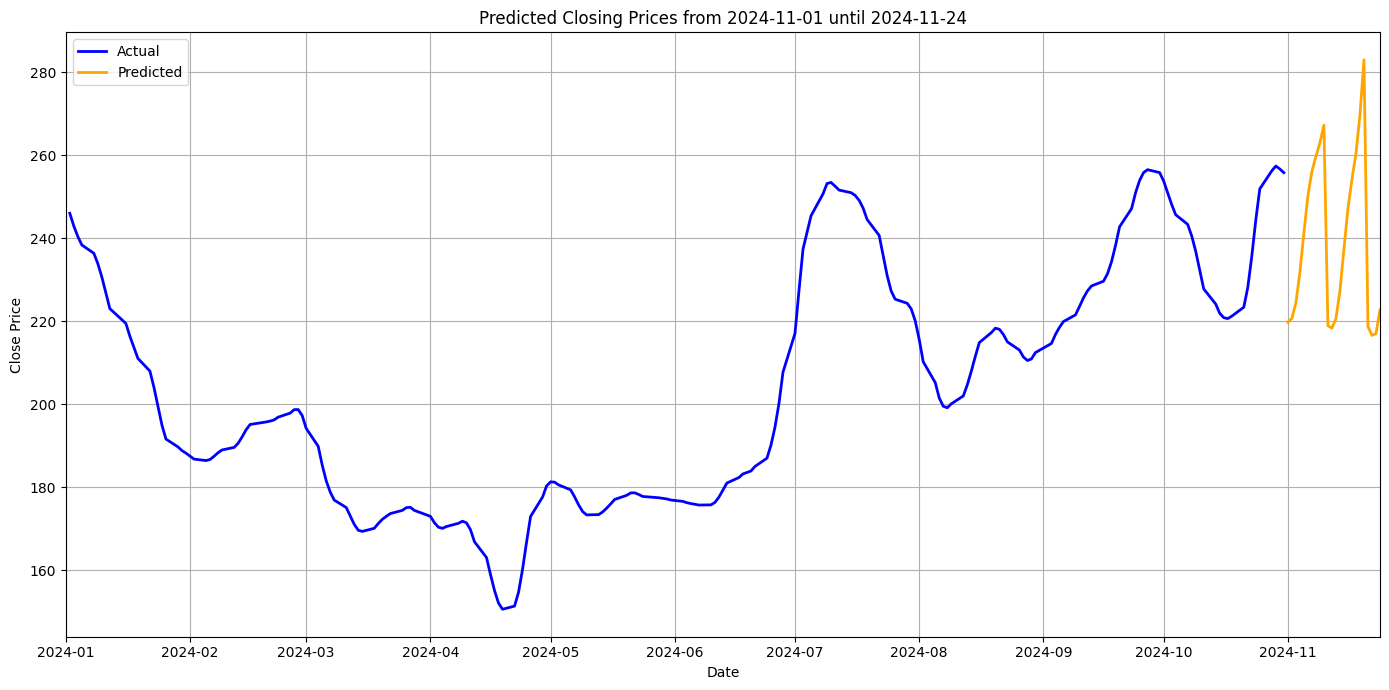

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to predict close prices for new dates
def predict_close_price(df, weights, bias, start_date, num_days, degree):
    # Create polynomial features object
    poly = PolynomialFeatures(degree=degree)

    predictions = []
    last_known_prices = df['Close'].values  # Last known 'close' prices

    # Get the last N close prices for initial prediction
    last_n_prices = last_known_prices[-N:]

    for _ in range(num_days):
        # Transform the last N prices into polynomial features
        last_n_prices_poly = poly.fit_transform(last_n_prices.reshape(1, -1))  # Reshape to 2D array

        # Calculate predicted close price for the next day
        predicted_close = np.dot(last_n_prices_poly, weights) + bias
        predictions.append(predicted_close[0])  # Append the scalar prediction

        # Update the last N prices for the next prediction
        last_n_prices = np.append(last_n_prices[1:], predicted_close)  # Shift and add new prediction

    return predictions

# Train the model with the best value of lagged features, which is N=4
N = 10
degree = 8
alpha = 1
_, _, _, _, _, _, weights, bias = polynomial_regression_model(degree, N, df, alpha)
print(weights)

# Make predictions starting from '2024-11-01' for 24 days
start_date = '2024-11-01'
num_days = 24
predicted_prices = predict_close_price(df, weights, bias, start_date, num_days, degree)

# Create a DataFrame for predicted prices with corresponding dates
predicted_dates = [pd.to_datetime(start_date) + pd.Timedelta(days=i) for i in range(num_days)]
predictions_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': predicted_prices})
print(predictions_df)

# Combine predictions with the initial DataFrame
df_combined = pd.concat([df, predictions_df], ignore_index=True)

# Plot the actual and predicted 'close' prices for all days
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df[df['Date'] >= '2024-01-01']['Date'], df[df['Date'] >= '2024-01-01']['Close'], label='Actual', color='blue', linewidth=2)
ax.plot(predictions_df['Date'], predictions_df['Predicted Close'], label='Predicted', color='orange', linestyle='-', linewidth=2)

# Set plot limits to show only year 2024 and onwards
ax.set_xlim([pd.to_datetime('2024-01-01'), predictions_df['Date'].max()])

ax.set_title('Predicted Closing Prices from 2024-11-01 until 2024-11-24')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()